In [19]:
# Step 1: Install Required Libraries
!pip install tensorflow keras scikit-learn xgboost opencv-python

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import os
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [21]:
# Step 3: Mount Google Drive (if your dataset is in Google Drive)
import zipfile
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Step 4: Load Data from fMRI Implementation
def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path

In [23]:
def load_and_preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (128, 128))  # Increase input size for more parameters
        img = img / 255.0  # Normalize
        images.append(img)
    return np.array(images)

In [24]:

# Step 4: Define the Path to the Zip File
# If the zip file is in Google Drive:
zip_path = '/content/drive/MyDrive/new_data.zip'

# If the zip file is uploaded directly to Colab:
# zip_path = '/content/your_zip_file.zip'

# Step 5: Define the Extraction Path
extract_path = '/content/new_data/new_data'
#extract_path = '/content/new_data'

# Step 6: Create the Extraction Directory (if it doesn't exist)
os.makedirs(extract_path, exist_ok=True)

# Step 7: Extract the Zip File
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

# Step 8: List Extracted Files (to verify)
extracted_files = os.listdir(extract_path)
print("Extracted Files:", extracted_files)

Files extracted to: /content/new_data/new_data
Extracted Files: ['test', 'new_data', 'train']


In [25]:
# Update the path to the extracted folder
train_Autism_imgs = create_images_list(os.path.join(extract_path, 'train/1'))
train_NonAutism_imgs = create_images_list(os.path.join(extract_path, 'train/2'))
test_Autism_imgs = create_images_list(os.path.join(extract_path, 'test/1'))
test_NonAutism_imgs = create_images_list(os.path.join(extract_path, 'test/2'))

In [26]:
train_ = pd.concat([pd.DataFrame({'image': train_Autism_imgs, 'label': 1}),
                    pd.DataFrame({'image': train_NonAutism_imgs, 'label': 0})])
test_ = pd.concat([pd.DataFrame({'image': test_Autism_imgs, 'label': 1}),
                   pd.DataFrame({'image': test_NonAutism_imgs, 'label': 0})])

In [27]:
full_data = pd.concat([train_, test_])
full_data = full_data.sample(frac=1, ignore_index=True, random_state=48)
train_data, test_data = train_test_split(full_data, test_size=0.2, stratify=full_data['label'])
train_data, valid_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label'])


In [28]:
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [29]:
# Print dataset statistics
print(f"Training data samples: {len(train_data)}")
print(f"Testing data samples: {len(test_data)}")
print(f"Validation data samples: {len(valid_data)}")

Training data samples: 4403
Testing data samples: 1376
Validation data samples: 1101


In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Bidirectional, LSTM, Dense, Flatten, TimeDistributed, BatchNormalization, Dropout, Reshape # Import Reshape

def create_cnn_bilstm_model(input_shape=(128, 128, 3), num_classes=1):
    # CNN layers
    input_layer = Input(shape=input_shape)
    cnn = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    cnn = MaxPooling2D((2, 2))(cnn)
    cnn = BatchNormalization()(cnn)

    cnn = Conv2D(64, (3, 3), activation='relu', padding='same')(cnn)
    cnn = MaxPooling2D((2, 2))(cnn)
    cnn = BatchNormalization()(cnn)

    cnn = Conv2D(128, (3, 3), activation='relu', padding='same')(cnn)
    cnn = MaxPooling2D((2, 2))(cnn)
    cnn = BatchNormalization()(cnn)

    # Flatten CNN output
    cnn = Flatten()(cnn)
    cnn = Dropout(0.3)(cnn)
    cnn = Dense(128, activation='relu')(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Dropout(0.3)(cnn)


    time_steps = 4
    features_per_step = cnn.shape[-1] // time_steps
    reshaped_cnn = Reshape((time_steps, features_per_step))(cnn)

    # BiLSTM layers
    bilstm = Bidirectional(LSTM(64, return_sequences=False))(reshaped_cnn)
    bilstm = BatchNormalization()(bilstm)
    bilstm = Dropout(0.5)(bilstm)

    # Output layer
    output_layer = Dense(num_classes, activation='sigmoid')(bilstm)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model
# Create the CNN-BiLSTM model
model = create_cnn_bilstm_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,339,393 (16.55 MB)

 Trainable params: 4,338,433 (16.55 MB)

 Non-trainable params: 960 (3.75 KB)

In [32]:
# Step 7: Load and Preprocess Data
X_train = load_and_preprocess_images(train_data['image'].values)
y_train = train_data['label'].values
X_test = load_and_preprocess_images(test_data['image'].values)
y_test = test_data['label'].values

Epoch 1/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5835 - loss: 0.8542

138/138 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.5838 - loss: 0.8536 - val_accuracy: 0.6240 - val_loss: 0.6836
Epoch 2/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.7037 - loss: 0.6101 - val_accuracy: 0.5713 - val_loss: 0.9203
Epoch 3/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.7169 - loss: 0.5762 - val_accuracy: 0.5132 - val_loss: 0.6934
Epoch 4/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8274 - loss: 0.3987

138/138 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.8275 - loss: 0.3985 - val_accuracy: 0.7293 - val_loss: 0.4993
Epoch 5/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8953 - loss: 0.2634

138/138 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.8954 - loss: 0.2632 - val_accuracy: 0.8420 - val_loss: 0.3316
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 322ms/step - accuracy: 0.8268 - loss: 0.3544
Test Accuracy: 0.8393895626068115


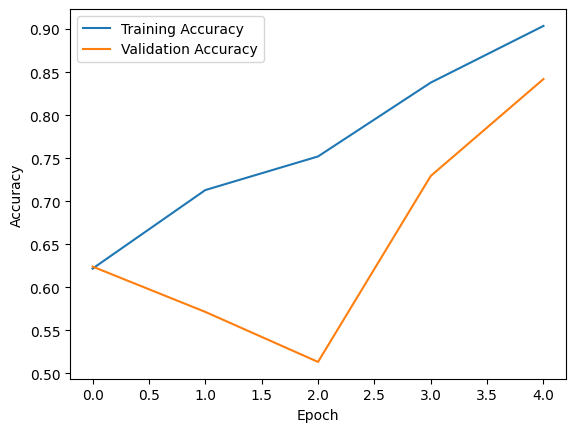

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_bilstm_best_model.h5', monitor='val_loss', save_best_only=True)

# Preprocess validation data
X_val = load_and_preprocess_images(valid_data['image'].values)  # Assuming 'valid_data' is your validation DataFrame
y_val = valid_data['label'].values

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Use the defined validation data
    epochs=5,  # Adjust as needed
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Extract features using the CNN-BiLSTM model
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
X_train_features = intermediate_layer_model.predict(X_train)
X_val_features = intermediate_layer_model.predict(X_val)
X_test_features = intermediate_layer_model.predict(X_test)

# Train XGBoost classifier
# The 'early_stopping_rounds' parameter is moved to the XGBClassifier constructor.
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', early_stopping_rounds=10)
xgb_model.fit(X_train_features, y_train,
              eval_set=[(X_val_features, y_val)])

# Make predictions
y_pred = xgb_model.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Test Accuracy: {accuracy}")

138/138 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 328ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 308ms/step


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:36:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.46814
[1]	validation_0-logloss:0.35162
[2]	validation_0-logloss:0.27443
[3]	validation_0-logloss:0.22245
[4]	validation_0-logloss:0.18400
[5]	validation_0-logloss:0.15670
[6]	validation_0-logloss:0.13600
[7]	validation_0-logloss:0.12006
[8]	validation_0-logloss:0.10739
[9]	validation_0-logloss:0.09738
[10]	validation_0-logloss:0.09084
[11]	validation_0-logloss:0.08483
[12]	validation_0-logloss:0.08027
[13]	validation_0-logloss:0.07968
[14]	validation_0-logloss:0.07584
[15]	validation_0-logloss:0.07537
[16]	validation_0-logloss:0.07227
[17]	validation_0-logloss:0.07267
[18]	validation_0-logloss:0.07239
[19]	validation_0-logloss:0.07271
[20]	validation_0-logloss:0.07272
[21]	validation_0-logloss:0.07382
[22]	validation_0-logloss:0.07309
[23]	validation_0-logloss:0.07333
[24]	validation_0-logloss:0.07297
[25]	validation_0-logloss:0.07337
XGBoost Test Accuracy: 0.9760174418604651


In [46]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier  # Import MLPClassifier
from sklearn.naive_bayes import GaussianNB         # Import GaussianNB

# Function to train and evaluate classifiers
def train_evaluate_classifier(classifier, X_train, y_train, X_test, y_test, param_grid=None):
    # Grid Search for hyperparameter tuning if param_grid is provided
    if param_grid:
        grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_classifier = grid_search.best_estimator_
        print("Best parameters:", grid_search.best_params_)
    else:
        best_classifier = classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = best_classifier.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return best_classifier

# Extract features using the CNN-BiLSTM model (Assuming this part is already done)
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
X_train_features = intermediate_layer_model.predict(X_train)
X_val_features = intermediate_layer_model.predict(X_val)
X_test_features = intermediate_layer_model.predict(X_test)

# Define classifiers
classifiers = {
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                  {'n_estimators': [100, 200], 'max_depth': [3, 5]}),
    "Random Forest": (RandomForestClassifier(random_state=42),
                      {'n_estimators': [100, 200], 'max_depth': [5, 10]}),
    "AdaBoost": (AdaBoostClassifier(random_state=42),
                 {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}),
    "Gradient Boosting": (GradientBoostingClassifier(random_state=42),
                           {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}),
    "SVM": (SVC(probability=True, random_state=42),
            {'C': [0.1, 1], 'kernel': ['rbf']}),
    "Logistic Regression": (LogisticRegression(random_state=42, solver='liblinear'),
                            {'C': [0.1, 1]}),
     "MLP": (MLPClassifier(random_state=42, max_iter=300),  # Add MLPClassifier
            {'hidden_layer_sizes': [(64,), (128,)], 'activation': ['relu', 'tanh']}),
}

# Train and evaluate each classifier
trained_classifiers = {}
for name, (classifier, param_grid) in classifiers.items():
    print(f"Training and evaluating {name}:")
    trained_classifier = train_evaluate_classifier(classifier, X_train_features, y_train,
                                                   X_test_features, y_test, param_grid)
    trained_classifiers[name] = trained_classifier
    print("="*40)


138/138 ━━━━━━━━━━━━━━━━━━━━ 49s 339ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 330ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 324ms/step
Training and evaluating XGBoost:


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:09:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'max_depth': 5, 'n_estimators': 200}
Accuracy: 0.9753
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       784
           1       0.96      0.98      0.97       592

    accuracy                           0.98      1376
   macro avg       0.97      0.98      0.97      1376
weighted avg       0.98      0.98      0.98      1376

Training and evaluating Random Forest:
Best parameters: {'max_depth': 10, 'n_estimators': 200}
Accuracy: 0.9811
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       784
           1       0.97      0.98      0.98       592

    accuracy                           0.98      1376
   macro avg       0.98      0.98      0.98      1376
weighted avg       0.98      0.98      0.98      1376

Training and evaluating AdaBoost:
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}
Accuracy: 0.9528
Cl

43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 327ms/step


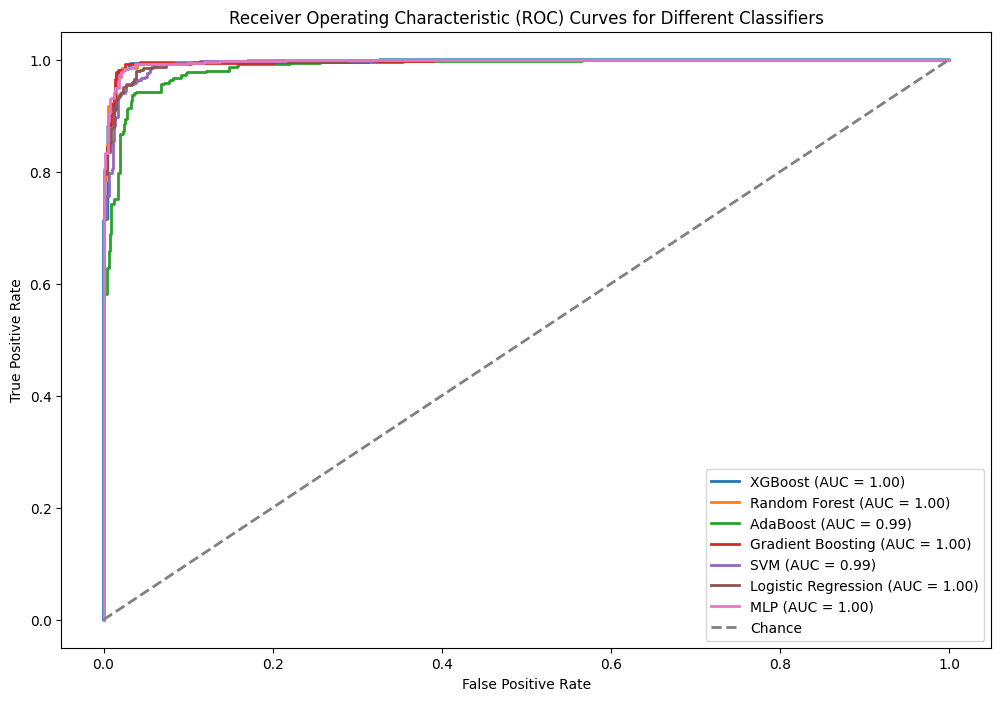

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Define a color palette for the plots
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])

# List of classifier names to iterate
classifier_names = ['XGBoost', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'SVM',
                      'Logistic Regression', 'MLP']

# Use the extracted features from the CNN-BiLSTM model
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
X_test_features = intermediate_layer_model.predict(X_test)

# --- Multi-class or Binary Case ---
if len(np.unique(y_test)) > 2:
    # --- Multi-class Case ---
    # Binarize the labels for multi-class ROC and PR curves
    y_bin = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_bin.shape[1]

    # Prepare ROC curve plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot ROC curve for each class and each classifier
    for name in classifier_names:
        classifier = trained_classifiers[name]
        if hasattr(classifier, "predict_proba"):
            y_prob = classifier.predict_proba(X_test_features)
        else:  # For classifiers without predict_proba, use decision_function
            y_prob = classifier.decision_function(X_test_features)
            # Need to apply a sigmoid transformation if output is not probabilities
            from scipy.special import softmax
            y_prob = softmax(y_prob, axis=1)

        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Macro-average ROC curve
        fpr_grid = np.linspace(0.0, 1.0, 1000)
        mean_tpr = np.zeros_like(fpr_grid)

        for i in range(n_classes):
            mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

        mean_tpr /= n_classes

        # Compute AUC based on the mean ROC curve
        mean_auc = auc(fpr_grid, mean_tpr)

        # Plot Mean ROC
        plt.plot(fpr_grid, mean_tpr, label=f'{name} (AUC = {mean_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Chance')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves for Different Classifiers')
    plt.legend(loc="lower right")
    plt.show()

else:
    # --- Binary classification Case ---
    # Prepare ROC curve plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot ROC curve for each classifier
    for name in classifier_names:
        classifier = trained_classifiers[name]
        if hasattr(classifier, "predict_proba"):
            y_prob = classifier.predict_proba(X_test_features)[:, 1]
        else:
            y_prob = classifier.decision_function(X_test_features)
            # Apply sigmoid if not probabilities
            y_prob = 1 / (1 + np.exp(-y_prob))

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Chance')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curves for Different Classifiers')
    ax.legend(loc="lower right")
    plt.show()


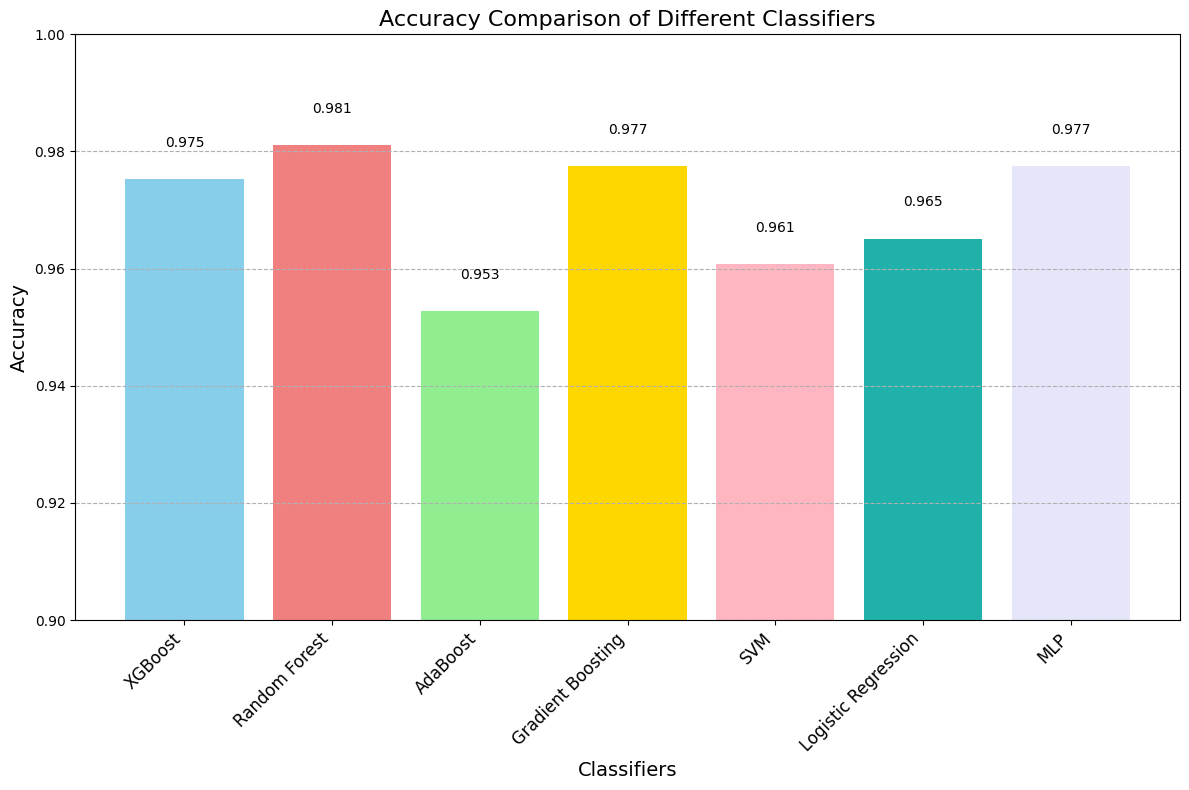

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Classifier names and corresponding accuracy scores
classifier_names = ['XGBoost', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'SVM',
                      'Logistic Regression', 'MLP']
accuracies = []

for name in classifier_names:
    classifier = trained_classifiers[name]  # Retrieve the trained classifier
    y_pred = classifier.predict(X_test_features)  # Get predictions
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    accuracies.append(accuracy)

# Define custom colors for the bars
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightpink',
          'lightseagreen', 'lavender']  # Extended color list

# Ensure there are enough colors for all classifiers
if len(colors) < len(classifier_names):
    raise ValueError("Not enough colors specified for the number of classifiers.")

# Plotting the bar graph
plt.figure(figsize=(12, 8))
bars = plt.bar(classifier_names, accuracies, color=colors)  # Use custom colors
plt.xlabel("Classifiers", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy Comparison of Different Classifiers", fontsize=16)
plt.ylim([0.9, 1])  # Setting y-axis limit from 0.9 to 1
plt.yticks(np.arange(0.9, 1.01, 0.02))  # Set specific y-ticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid(axis='y', linestyle='--')  # Add grid lines for better readability

# Add accuracy values on top of the bars
for bar, accuracy in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(accuracy, 3),
             ha='center', va='bottom', fontsize=10)

# Display the plot
plt.show()


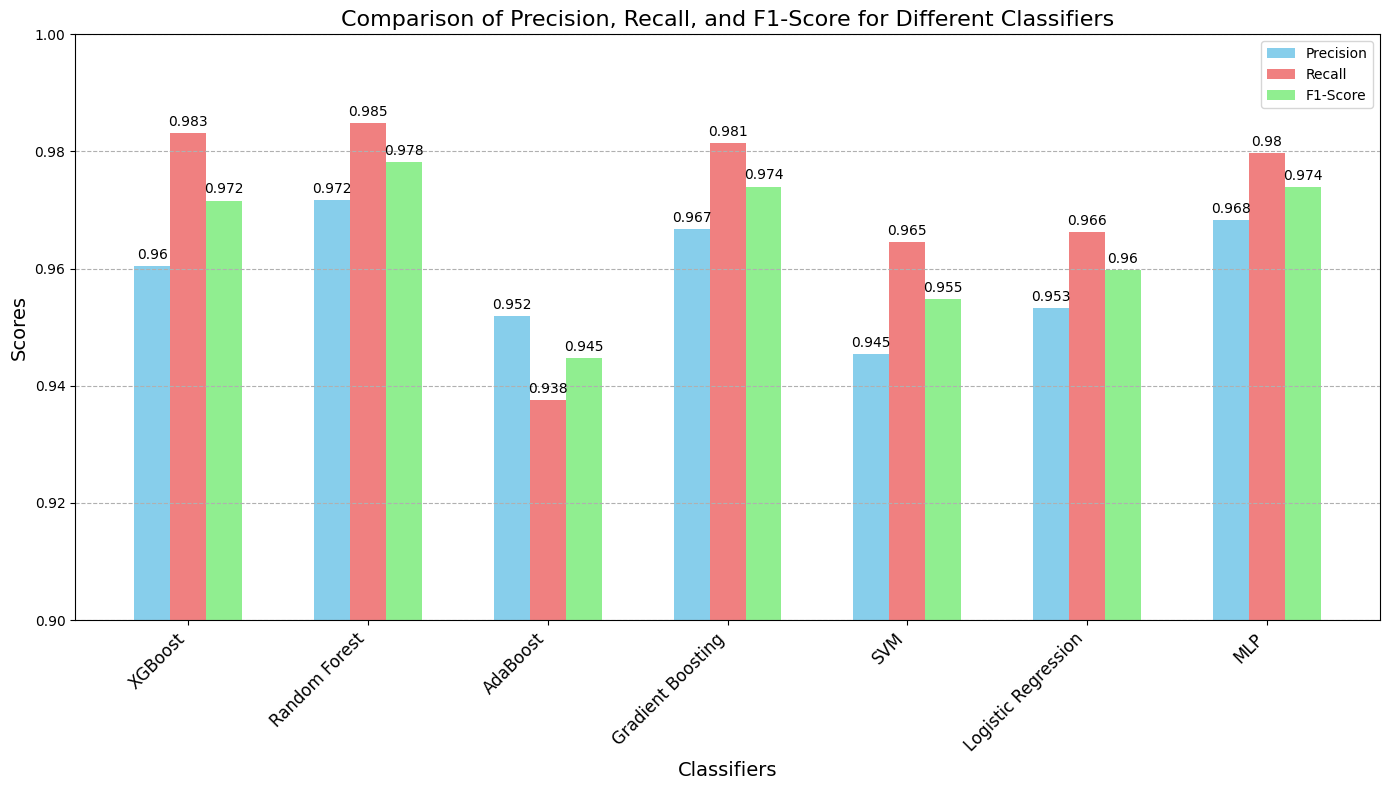

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Classifier names
classifier_names = ['XGBoost', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'SVM',
                      'Logistic Regression', 'MLP']

# Metrics dictionary
metrics = {
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Compute and store metrics for each classifier
for name in classifier_names:
    classifier = trained_classifiers[name]
    y_pred = classifier.predict(X_test_features)
    metrics['Precision'].append(precision_score(y_test, y_pred, average='binary'))
    metrics['Recall'].append(recall_score(y_test, y_pred, average='binary'))
    metrics['F1-Score'].append(f1_score(y_test, y_pred, average='binary'))

# Plotting the grouped bar graph
x = np.arange(len(classifier_names))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width, metrics['Precision'], width, label='Precision', color='skyblue')
rects2 = ax.bar(x, metrics['Recall'], width, label='Recall', color='lightcoral')
rects3 = ax.bar(x + width, metrics['F1-Score'], width, label='F1-Score', color='lightgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores', fontsize=14)
ax.set_xlabel('Classifiers', fontsize=14)
ax.set_title('Comparison of Precision, Recall, and F1-Score for Different Classifiers', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=12)
ax.set_ylim([0.9, 1])  # Setting y-axis limit from 0.9 to 1
ax.set_yticks(np.arange(0.9, 1.01, 0.02))  # Set specific y-ticks
ax.legend()
ax.grid(axis='y', linestyle='--')

# Function to add value labels
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()


In [47]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Classifier names (excluding Naive Bayes)
classifier_names = ['Random Forest', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'SVM', 'Logistic Regression', 'MLP']

# Create a dictionary to store the metrics
metrics = {
    'Classifier': classifier_names,
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Populate the metrics dictionary
for name in classifier_names:
    classifier = trained_classifiers[name]  # Retrieve the trained classifier
    y_pred = classifier.predict(X_test_features)  # Get predictions
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['Precision'].append(precision_score(y_test, y_pred, average='binary'))
    metrics['Recall'].append(recall_score(y_test, y_pred, average='binary'))
    metrics['F1-Score'].append(f1_score(y_test, y_pred, average='binary'))

# Create a DataFrame from the metrics dictionary
df = pd.DataFrame(metrics)

# Sort the DataFrame by Accuracy in descending order
df_sorted = df.sort_values(by='Accuracy', ascending=False)

# Display the table
print(df_sorted.to_string(index=False))


         Classifier  Accuracy  Precision   Recall  F1-Score
      Random Forest  0.981105   0.971667 0.984797  0.978188
                MLP  0.977471   0.968280 0.979730  0.973971
  Gradient Boosting  0.977471   0.966722 0.981419  0.974015
            XGBoost  0.975291   0.960396 0.983108  0.971619
Logistic Regression  0.965116   0.953333 0.966216  0.959732
                SVM  0.960756   0.945364 0.964527  0.954849
           AdaBoost  0.952762   0.951973 0.937500  0.944681


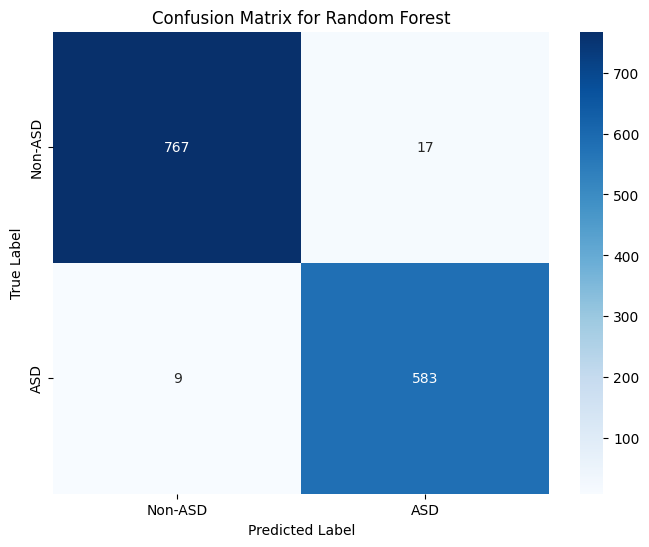

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the Random Forest classifier from the trained classifiers
rf_classifier = trained_classifiers['Random Forest']

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_features)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-ASD', 'ASD'],
            yticklabels=['Non-ASD', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest')
plt.show()
